In [1]:
import tensorflow as tf

## Reviewing previous sessions

In [3]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    

In [4]:
from sklearn.datasets import fetch_california_housing

class DataLoader():
    def __init__(self, batch_size=32):
        self.b = batch_size
        housing_data = fetch_california_housing()
        self.X = housing_data.data
        self.Y = np.reshape(housing_data.target, [-1, 1])
        self.Y = np.log(self.Y)
        self.X = self.X / np.std(self.X, axis=0)
        self.n = len(self.X)
        self.X_train, self.Y_train = self.X[: self.n // 2], self.Y[: self.n // 2]
        self.X_val, self.Y_val = self.X[self.n // 2:], self.Y[self.n // 2:]
        self.n_train, self.n_val = len(self.X_train), len(self.X_val)
        self.tp, self.vp = 0, 0
        
    
    def get_train_batch(self):
        if self.tp >= self.n_train:
            self.tp = 0
        xb, yb = self.X_train[self.tp: self.tp + self.b], self.Y_train[self.tp: self.tp + self.b]
        self.tp += self.b
        return xb, yb
    
    def get_val_batch(self):
        if self.vp >= self.n_train:
            self.vp = 0
        xb, yb = self.X_val[self.vp: self.vp + self.b], self.Y_val[self.vp: self.vp + self.b]
        self.vp += self.b
        return xb, yb
    
dataloader = DataLoader(batch_size=5) 

In [5]:
import os
import datetime

class Model():
    def __init__(self, name='Model', dataloader=None):
        self.name = name
        self.dataloader = dataloader
        
        self.save_path = os.path.join("SavedModels/", self.name)
        try:
            os.mkdir(self.save_path)
        except:
            pass
        
        init_time = datetime.datetime.utcnow().strftime("%Y%m%d%H%M%S")
        self.log_path = os.path.join("log/" + self.name + "-run-" + init_time)
        
        self.create_graph()
        self.ses = tf.Session()
        
    
    def create_graph(self):
        tf.reset_default_graph()
        tf.set_random_seed(42)
        with tf.variable_scope(self.name):
            with tf.variable_scope("Placeholders"):
                self.x_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 8]) # dataloader must provide the shape
                self.y_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 1])
            
            with tf.variable_scope("Inference"):
                h1 = tf.layers.dense(inputs=self.x_placeholder, units=16, activation=tf.nn.sigmoid, name='layer1')
                h2 = tf.layers.dense(inputs=h1, units=8, activation=tf.nn.sigmoid, name='layer2')
                self.y_hat = tf.layers.dense(inputs=h2, units=1, name='y_hat')
                
            with tf.variable_scope("Optimization"):
                self.loss = tf.losses.mean_squared_error(labels=self.y_placeholder, predictions=self.y_hat)
                self.global_step = tf.train.get_or_create_global_step()
                learning_rate = tf.train.exponential_decay(learning_rate=1e-4, # 1e-3
                                                           decay_steps=1000,
                                                           decay_rate=0.5,
                                                           global_step=self.global_step,
                                                           name='learning_rate')
                optimizer = tf.train.GradientDescentOptimizer(learning_rate)
                self.train_operation = optimizer.minimize(self.loss, global_step=self.global_step)
                
            with tf.variable_scope("Init_save"):
                self.variable_initializer = tf.global_variables_initializer()
                self.saver = tf.train.Saver()
                
            with tf.variable_scope("Summary"):
                self.train_summary_writer = tf.summary.FileWriter(self.log_path + "train", tf.get_default_graph())
                self.validation_summary_writer = tf.summary.FileWriter(self.log_path + "validation")
                self.loss_summary = tf.summary.scalar(name="Mean_Squared_Loss", tensor=self.loss)
                
                
    def train(self, init=True, steps=10000):
        if init:
            self.ses.run(self.variable_initializer)
        step = 0
        while step < steps:
            x_train, y_train = self.dataloader.get_train_batch()
            x_val, y_val = self.dataloader.get_val_batch()
            val_loss_summary = self.ses.run(self.loss_summary, feed_dict={self.x_placeholder: x_val, self.y_placeholder: y_val})
            train_loss_summary, step, _ = self.ses.run([self.loss_summary, self.global_step, self.train_operation],
                                               feed_dict={self.x_placeholder: x_train, self.y_placeholder: y_train})
            self.train_summary_writer.add_summary(train_loss_summary, step)
            self.validation_summary_writer.add_summary(val_loss_summary, step)
            if step % 1000 == 0:
                print("Step = ", step)
                
        self.train_summary_writer.close()
        self.validation_summary_writer.close()
                
    
    def save(self):
        self.saver.save(self.ses, save_path=self.save_path + "/" + self.name + '.ckpt')
    
    def load(self):
        self.saver.restore(self.ses, save_path=self.save_path + "/" + self.name + '.ckpt')

            

In [6]:
dataloader = DataLoader(batch_size=64)
M1 = Model(name="M1", dataloader=dataloader)
# show_graph(tf.get_default_graph())
M1.train(init=True, steps=4000)
# M1.save()
# M1.load()

Step =  0
Step =  1000
Step =  2000
Step =  3000
Step =  4000


# Hands on Mnist (More Summaries, Changing DataLoader, ...)

## More summaries

In [7]:
import gzip, numpy
import pickle

class DataLoader():
    def __init__(self, batch_size=32):
        self.b = batch_size
        # Load the dataset
        with gzip.open('Dataset/mnist.pkl.gz', 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            train_set, val_set, _ = u.load()
        
        self.X_train, self.Y_train = train_set
        self.X_val, self.Y_val = val_set
        self.X_train = np.reshape(self.X_train, [-1, 28, 28, 1])
        self.X_val = np.reshape(self.X_val, [-1, 28, 28, 1])

        
        self.n_train, self.n_val = len(self.X_train), len(self.X_val)
        self.tp, self.vp = 0, 0
        
    
    def get_train_batch(self):
        if self.tp >= self.n_train - 1:
            self.tp = 0
        xb, yb = self.X_train[self.tp: self.tp + self.b], self.Y_train[self.tp: self.tp + self.b]
        self.tp += self.b
        return xb, yb
    
    def get_val_batch(self):
        if self.vp >= self.n_val - 1:
            self.vp = 0
        xb, yb = self.X_val[self.vp: self.vp + self.b], self.Y_val[self.vp: self.vp + self.b]
        self.vp += self.b
        return xb, yb
    
dataloader = DataLoader(batch_size=5)
dataloader.get_train_batch()[1].shape

(5,)

In [8]:
import os
import datetime

class Model():
    def __init__(self, name='Model', dataloader=None):
        self.name = name
        self.dataloader = dataloader
        
        self.save_path = os.path.join("SavedModels/", self.name)
        try:
            os.mkdir(self.save_path)
        except:
            pass
        
        init_time = datetime.datetime.utcnow().strftime("%Y%m%d%H%M%S")
        self.log_path = os.path.join("log/" + self.name + "-run-" + init_time)
        
        self.create_graph()
        self.ses = tf.Session()
        
    
    def create_graph(self):
        tf.reset_default_graph()
        tf.set_random_seed(42)
        with tf.variable_scope(self.name):
            with tf.variable_scope("Placeholders"):
                self.x_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1]) # dataloader must provide the shape
                self.y_placeholder = tf.placeholder(dtype=tf.int64, shape=[None])
            
            with tf.variable_scope("Inference"):
                x_flattened = tf.layers.flatten(self.x_placeholder, name='x_flattened')
                h1 = tf.layers.dense(inputs=x_flattened, units=128, activation=tf.nn.tanh, name='layer1')
                self.logits = tf.layers.dense(inputs=h1, units=10, name='y_hat')
                self.y_hat_probs = tf.nn.softmax(self.logits, name='y_hat_probs')
                
            with tf.variable_scope("Optimization"):
                batch_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y_placeholder,
                                                                            logits=self.logits,
                                                                            name='batch_loss')
                self.loss = tf.reduce_mean(batch_loss, name='loss')
                batch_accuracy = tf.cast(
                    tf.equal(
                        tf.argmax(self.y_hat_probs, axis=1),
                        self.y_placeholder
                    ), dtype=tf.float32)
                self.accuracy = tf.reduce_mean(batch_accuracy)
                self.global_step = tf.train.get_or_create_global_step()
                learning_rate = tf.train.exponential_decay(learning_rate=1e-2, # 1e-3
                                                           decay_steps=2000,
                                                           decay_rate=0.5,
                                                           global_step=self.global_step,
                                                           name='learning_rate')
                optimizer = tf.train.AdagradOptimizer(learning_rate)
                self.train_operation = optimizer.minimize(self.loss, global_step=self.global_step)
                
                ################### $ ###################
                layer1_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name + "/Inference/layer1/")
                print(layer1_variables)
                layer1_gradients = tf.gradients(self.loss, layer1_variables)
                layer1_gradient_norm = tf.norm(layer1_gradients[0], name='layer1_gradient_norm')
                ################### $ ###################
                
            with tf.variable_scope("Init_save"):
                self.variable_initializer = tf.global_variables_initializer()
                self.saver = tf.train.Saver()
                
            with tf.variable_scope("Summary"):
                self.loss_summary = tf.summary.scalar(name="Cross_Entropy_Loss", tensor=self.loss)
                self.accuracy_summary = tf.summary.scalar(name="Accuracy", tensor=self.accuracy)
                self.eval_summaries = tf.summary.merge([self.loss_summary, self.accuracy_summary])
                
                ################### $ ###################
                self.layer1_gradient_norm_summary = tf.summary.scalar(name="layer1_gradient_norm", 
                                                                      tensor=layer1_gradient_norm)
                self.layer1_kernel_histogram_summary = tf.summary.histogram(name='layer1_kernel_histogram', 
                                                                            values=layer1_variables[0])
                self.learning_rate_summary = tf.summary.scalar(name='learning_rate', tensor=learning_rate)
                
                self.input_image_summary = tf.summary.image(name='input_image', tensor=self.x_placeholder, max_outputs=3)
                neuron_activity = tf.reshape(tf.transpose(layer1_variables[0]), [128, 28, 28, 1], name='neuron_activity')
                self.neuron_activity_summary = tf.summary.image(name='neuron_activity',
                                                                tensor=neuron_activity,
                                                                max_outputs=3)
                self.merged_summaries = tf.summary.merge_all()
                ################### $ ###################
                
                self.train_summary_writer = tf.summary.FileWriter(self.log_path + "train", tf.get_default_graph())
                self.validation_summary_writer = tf.summary.FileWriter(self.log_path + "validation")
    
                
                
                
    def train(self, init=True, steps=10000):
        if init:
            self.ses.run(self.variable_initializer)
        step = 0
        while step < steps:
            x_train, y_train = self.dataloader.get_train_batch()
            x_val, y_val = self.dataloader.get_val_batch()
            val_loss_summary = self.ses.run(self.eval_summaries, feed_dict={self.x_placeholder: x_val, self.y_placeholder: y_val})
            train_summary, step, _ = self.ses.run([self.merged_summaries, self.global_step, self.train_operation],
                                               feed_dict={self.x_placeholder: x_train, self.y_placeholder: y_train})
            
            if step % 100 == 0:
                self.train_summary_writer.add_summary(train_summary, step)
                self.validation_summary_writer.add_summary(val_loss_summary, step)
                ################### $ ###################
#                 self.train_summary_writer.flush()
    #             self.validation_summary_writer.flush()
                ################### $ ###################
            if step % 1000 == 0:
                print("Step = ", step)
                
        self.train_summary_writer.close()
        self.validation_summary_writer.close()
                
    
    def save(self):
        self.saver.save(self.ses, save_path=self.save_path + "/" + self.name + '.ckpt')
    
    def load(self):
        self.saver.restore(self.ses, save_path=self.save_path + "/" + self.name + '.ckpt')

            

In [9]:
dataloader = DataLoader(batch_size=64)
M2 = Model(name="M2", dataloader=dataloader)
# show_graph(tf.get_default_graph())
M2.train(init=True, steps=10000)
# M2.save()
# M1.load()

[<tf.Variable 'M2/Inference/layer1/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'M2/Inference/layer1/bias:0' shape=(128,) dtype=float32_ref>]
Step =  0
Step =  1000
Step =  2000
Step =  3000
Step =  4000
Step =  5000
Step =  6000
Step =  7000
Step =  8000
Step =  9000
Step =  10000


## Changing the DataLoader

### Python generator

In [11]:
import numpy as np
np.random.seed(42)
def generator():
    while True:
        yield np.random.rand()
        
i = 0
for x in generator():
    print(x)
    i += 1
    if i == 5:
        break
    

0.3745401188473625
0.9507143064099162
0.7319939418114051
0.5986584841970366
0.15601864044243652


### Implementing the DataLoader

In [12]:
import gzip, numpy
import pickle

class DataLoader():
    def __init__(self, batch_size=32):
        self.b = batch_size
        # Load the dataset
        with gzip.open('Dataset/mnist.pkl.gz', 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            train_set, val_set, _ = u.load()
        
        self.X_train, self.Y_train = train_set
        self.X_val, self.Y_val = val_set
        self.X_train = np.reshape(self.X_train, [-1, 28, 28, 1])
        self.X_val = np.reshape(self.X_val, [-1, 28, 28, 1])
     
        self.n_train, self.n_val = len(self.X_train), len(self.X_val)
        
        self.train_dataset_initializer, self.train_dataset_batch = self.create_dataset(self.train_generator)
        self.val_dataset_initializer, self.val_dataset_batch = self.create_dataset(self.val_generator)
        
    def train_generator(self):
        for i in range(self.n_train):
            yield self.X_train[i], self.Y_train[i]
            
    def val_generator(self):
        for i in range(self.n_val):
            yield self.X_val[i], self.Y_val[i]
            
    def create_dataset(self, generator):
        output_shapes = (
                tf.TensorShape([28, 28, 1]),
                tf.TensorShape([])
        )
        dataset = tf.data.Dataset.from_generator(generator=generator,
                                                 output_types=(tf.float32, tf.int64),
                                                 output_shapes=output_shapes
                                                )
        
        dataset_iterator = dataset.make_initializable_iterator()
        dataset_initializer = dataset_iterator.initializer
        dataset_batch = dataset_iterator.get_next()
        return dataset_initializer, dataset_batch
        
        
    
tf.reset_default_graph()
dataloader = DataLoader(batch_size=5)
with tf.Session() as ses:
    ses.run(dataloader.train_dataset_initializer)
    x, y = ses.run(dataloader.train_dataset_batch)
x.shape, y

((28, 28, 1), 5)

#### Augmenting data

In [13]:
from scipy.ndimage import rotate
def augment(image):
    augmented_images = [image >= 0.5]
    for degree in [-20, -10, 10, 20]:
        rotated_image = rotate(image, degree, reshape=False)
        rotated_image_thresholded = rotated_image >= 0.5
        
        augmented_images.append(rotated_image_thresholded)
    return augmented_images

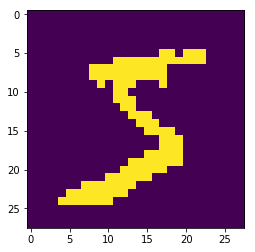

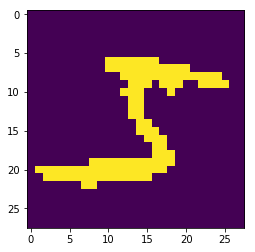

In [15]:
import gzip, numpy
import pickle

class DataLoader():
    def __init__(self, batch_size=32):
        self.b = batch_size
        # Load the dataset
        with gzip.open('Dataset/mnist.pkl.gz', 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            train_set, val_set, _ = u.load()
        
        self.X_train, self.Y_train = train_set
        self.X_val, self.Y_val = val_set
        self.X_train = np.reshape(self.X_train, [-1, 28, 28, 1])
        self.X_val = np.reshape(self.X_val, [-1, 28, 28, 1])
     
        self.n_train, self.n_val = len(self.X_train), len(self.X_val)
        
        self.train_dataset_initializer, self.train_dataset_batch = self.create_dataset(self.train_generator)
        self.val_dataset_initializer, self.val_dataset_batch = self.create_dataset(self.val_generator)
        
    def train_generator(self):
        for i in range(self.n_train):
            for x in augment(self.X_train[i]):
                yield x, self.Y_train[i]
            
    def val_generator(self):
        for i in range(self.n_train):
            yield self.X_train[i], self.Y_train[i]
            
    def create_dataset(self, generator):
        output_shapes = (
                tf.TensorShape([28, 28, 1]),
                tf.TensorShape([])
        )
        dataset = tf.data.Dataset.from_generator(generator=generator,
                                                 output_types=(tf.float32, tf.int64),
                                                 output_shapes=output_shapes
                                                )
        
        dataset_iterator = dataset.make_initializable_iterator()
        dataset_initializer = dataset_iterator.initializer
        dataset_batch = dataset_iterator.get_next()
        return dataset_initializer, dataset_batch
        
        
import matplotlib.pyplot as plt
tf.reset_default_graph()
dataloader = DataLoader(batch_size=5)
with tf.Session() as ses:
    ses.run(dataloader.train_dataset_initializer)
    x, y = ses.run(dataloader.train_dataset_batch)
    plt.figure()
    plt.imshow(x[:, :, 0])
    x, y = ses.run(dataloader.train_dataset_batch)
    

    plt.figure()
    plt.imshow(x[:, :, 0])
    
    
plt.show()


#### Shuffle, Batch, Prefetch, Repeat

In [19]:
import gzip, numpy
import pickle

def augment(image):
    augmented_images = [image >= 0.5]
    for degree in [-20, -10, 10, 20]:
        rotated_image = rotate(image, degree, reshape=False)
        rotated_image_thresholded = rotated_image >= 0.5
        
        augmented_images.append(rotated_image_thresholded)
    return augmented_images

class DataLoader():
    def __init__(self, batch_size=32):
        self.b = batch_size
        # Load the dataset
        with gzip.open('Dataset/mnist.pkl.gz', 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            train_set, val_set, _ = u.load()
        
        self.X_train, self.Y_train = train_set
        self.X_val, self.Y_val = val_set
        self.X_train = np.reshape(self.X_train, [-1, 28, 28, 1])
        self.X_val = np.reshape(self.X_val, [-1, 28, 28, 1])
     
        self.n_train, self.n_val = len(self.X_train), len(self.X_val)
        
#         tf.set_random_seed(42)
        self.train_dataset_initializer, self.train_dataset_batch = self.create_dataset(self.train_generator)
        self.val_dataset_initializer, self.val_dataset_batch = self.create_dataset(self.val_generator)
        
    def train_generator(self):
        for i in range(self.n_train):
            for x in augment(self.X_train[i]):
                yield x, self.Y_train[i]
            
    def val_generator(self):
        for i in range(self.n_train):
            yield self.X_train[i], self.Y_train[i]
            
    def create_dataset(self, generator):
        output_shapes = (
                tf.TensorShape([28, 28, 1]),
                tf.TensorShape([])
        )
        dataset = tf.data.Dataset.from_generator(generator=generator,
                                                 output_types=(tf.float32, tf.int64),
                                                 output_shapes=output_shapes
                                                )
        
        
        dataset = dataset.prefetch(self.b * 5)
        dataset = dataset.shuffle(buffer_size=self.b * 5)
        dataset = dataset.batch(self.b)
        dataset_iterator = dataset.make_initializable_iterator()
        dataset_initializer = dataset_iterator.initializer
        dataset_batch = dataset_iterator.get_next()
        return dataset_initializer, dataset_batch

        
   

tf.reset_default_graph()
dataloader = DataLoader(batch_size=64)

# import matplotlib.pyplot as plt
# with tf.Session() as ses:
#     ses.run(dataloader.train_dataset_initializer)
#     x, y = ses.run(dataloader.train_dataset_batch)
#     plt.figure()
#     plt.imshow(x[:, :, 0])
#     x, y = ses.run(dataloader.train_dataset_batch)
    

#     plt.figure()
#     plt.imshow(x[:, :, 0])
    
    
with tf.Session() as ses:
    ses.run(dataloader.train_dataset_initializer)
    x, y = ses.run(dataloader.train_dataset_batch)
    print(x.shape, y.shape)
    print(x.shape, y.dtype)


(64, 28, 28, 1) (64,)
(64, 28, 28, 1) int64


#### What happens when we reach to the end of dataset?

In [20]:
tf.reset_default_graph()
dataloader = DataLoader(batch_size=64)
# with tf.Session() as ses:
#     ses.run(dataloader.val_dataset_initializer)
#     while True:
#         x, y = ses.run(dataloader.val_dataset_batch) # OutOfRangeError (see above for traceback): End of sequence
    

with tf.Session() as ses:
    ses.run(dataloader.val_dataset_initializer)
    while True:
        try:
            x, y = ses.run(dataloader.val_dataset_batch) # OutOfRangeError (see above for traceback): End of sequence
        except tf.errors.OutOfRangeError:
            ses.run(dataloader.val_dataset_initializer)
            print("ReInitializing dataset")


OutOfRangeError: End of sequence
	 [[node IteratorGetNext_1 (defined at <ipython-input-19-0eda62809dbf>:58)  = IteratorGetNext[output_shapes=[[?,28,28,1], [?]], output_types=[DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](IteratorV2_1)]]

Caused by op 'IteratorGetNext_1', defined at:
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\tornado\platform\asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\tornado\platform\asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\ehsan\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-036955c32f5a>", line 2, in <module>
    dataloader = DataLoader(batch_size=64)
  File "<ipython-input-19-0eda62809dbf>", line 31, in __init__
    self.val_dataset_initializer, self.val_dataset_batch = self.create_dataset(self.val_generator)
  File "<ipython-input-19-0eda62809dbf>", line 58, in create_dataset
    dataset_batch = dataset_iterator.get_next()
  File "C:\Users\Ehsan\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 421, in get_next
    name=name)), self._output_types,
  File "C:\Users\Ehsan\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 2108, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "C:\Users\Ehsan\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Ehsan\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Ehsan\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\Users\Ehsan\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

OutOfRangeError (see above for traceback): End of sequence
	 [[node IteratorGetNext_1 (defined at <ipython-input-19-0eda62809dbf>:58)  = IteratorGetNext[output_shapes=[[?,28,28,1], [?]], output_types=[DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](IteratorV2_1)]]


## Putting it all together

In [21]:
import gzip, numpy
import pickle
from scipy.ndimage import rotate


def augment(image):
    augmented_images = [image >= 0.5]
    for degree in [-20, -10, 10, 20]:
        rotated_image = rotate(image, degree, reshape=False)
        rotated_image_thresholded = rotated_image >= 0.5
        
        augmented_images.append(rotated_image_thresholded)
    return augmented_images

class DataLoader():
    def __init__(self, batch_size=32):
        self.b = batch_size
        # Load the dataset
        with gzip.open('Dataset/mnist.pkl.gz', 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            train_set, val_set, _ = u.load()
        
        self.X_train, self.Y_train = train_set
        self.X_val, self.Y_val = val_set
        self.X_train = np.reshape(self.X_train, [-1, 28, 28, 1])
        self.X_val = np.reshape(self.X_val, [-1, 28, 28, 1])
     
        self.n_train, self.n_val = len(self.X_train), len(self.X_val)
        
#         tf.set_random_seed(42)
        self.train_dataset_initializer, self.train_dataset_batch = self.create_dataset(self.train_generator)
        self.val_dataset_initializer, self.val_dataset_batch = self.create_dataset(self.val_generator)
        
    def train_generator(self):
        for i in range(self.n_train):
            for x in augment(self.X_train[i]):
                yield x, self.Y_train[i]
            
    def val_generator(self):
        for i in range(self.n_train):
            yield self.X_train[i], self.Y_train[i]
            
    def create_dataset(self, generator):
        output_shapes = (
                tf.TensorShape([28, 28, 1]),
                tf.TensorShape([])
        )
        dataset = tf.data.Dataset.from_generator(generator=generator,
                                                 output_types=(tf.float32, tf.int64),
                                                 output_shapes=output_shapes
                                                )
        
        
        dataset = dataset.prefetch(self.b * 5)
        dataset = dataset.shuffle(buffer_size=self.b * 5)
        dataset = dataset.batch(self.b)
        dataset_iterator = dataset.make_initializable_iterator()
        dataset_initializer = dataset_iterator.initializer
        dataset_batch = dataset_iterator.get_next()
        return dataset_initializer, dataset_batch        

In [25]:
import os
import datetime

class Model():
    def __init__(self, name='Model'):
        self.name = name
        
        self.save_path = os.path.join("SavedModels/", self.name)
        try:
            os.mkdir(self.save_path)
        except:
            pass
        
        init_time = datetime.datetime.utcnow().strftime("%Y%m%d%H%M%S")
        self.log_path = os.path.join("log/" + self.name + "-run-" + init_time)
        
        self.create_graph()
        self.ses = tf.Session()
        
    
    def create_graph(self):
        tf.reset_default_graph()
        tf.set_random_seed(42)
        with tf.variable_scope(self.name):
            with tf.variable_scope("DataLoader"):
                self.dataloader = DataLoader(batch_size=64)
                self.x_train, self.y_train = self.dataloader.train_dataset_batch
                self.x_val, self.y_val = self.dataloader.val_dataset_batch
                self.train_dataset_initializer = self.dataloader.train_dataset_initializer
                self.val_dataset_initializer = self.dataloader.val_dataset_initializer
                
            with tf.variable_scope("Placeholders"):
#                 self.x_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1]) # dataloader must provide the shape
#                 self.y_placeholder = tf.placeholder(dtype=tf.int64, shape=[None])
                self.x_placeholder = tf.placeholder_with_default(self.x_train,
                                                                shape=[None, 28, 28, 1],
                                                                name='x_placeholder')
                self.y_placeholder = tf.placeholder_with_default(self.y_train,
                                                                shape=[None],
                                                                name='y_placeholder')
    
            
            with tf.variable_scope("Inference"):
                x_flattened = tf.layers.flatten(self.x_placeholder, name='x_flattened')
                h1 = tf.layers.dense(inputs=x_flattened, units=128, activation=tf.nn.tanh, name='layer1')
                self.logits = tf.layers.dense(inputs=h1, units=10, name='y_hat')
                self.y_hat_probs = tf.nn.softmax(self.logits, name='y_hat_probs')
                
            with tf.variable_scope("Optimization"):
                batch_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y_placeholder,
                                                                            logits=self.logits,
                                                                            name='batch_loss')
                self.loss = tf.reduce_mean(batch_loss, name='loss')
                batch_accuracy = tf.cast(
                    tf.equal(
                        tf.argmax(self.y_hat_probs, axis=1),
                        self.y_placeholder
                    ), dtype=tf.float32)
                self.accuracy = tf.reduce_mean(batch_accuracy)
                self.global_step = tf.train.get_or_create_global_step()
                learning_rate = tf.train.exponential_decay(learning_rate=1e-2, # 1e-3
                                                           decay_steps=2000,
                                                           decay_rate=0.5,
                                                           global_step=self.global_step,
                                                           name='learning_rate')
                optimizer = tf.train.AdagradOptimizer(learning_rate)
                self.train_operation = optimizer.minimize(self.loss, global_step=self.global_step)
                
                ################### $ ###################
                layer1_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name + "/Inference/layer1/")
                layer1_gradients = tf.gradients(self.loss, layer1_variables)
                layer1_gradient_norm = tf.norm(layer1_gradients[0], name='layer1_gradient_norm')
                ################### $ ###################
                
            with tf.variable_scope("Init_save"):
                self.variable_initializer = tf.global_variables_initializer()
                self.saver = tf.train.Saver()
                
            with tf.variable_scope("Summary"):
                self.loss_summary = tf.summary.scalar(name="Cross_Entropy_Loss", tensor=self.loss)
                self.accuracy_summary = tf.summary.scalar(name="Accuracy", tensor=self.accuracy)
                self.eval_summaries = tf.summary.merge([self.loss_summary, self.accuracy_summary])
                
                ################### $ ###################
                self.layer1_gradient_norm_summary = tf.summary.scalar(name="layer1_gradient_norm", 
                                                                      tensor=layer1_gradient_norm)
                self.layer1_kernel_histogram_summary = tf.summary.histogram(name='layer1_kernel_histogram', 
                                                                            values=layer1_variables[0])
                self.learning_rate_summary = tf.summary.scalar(name='learning_rate', tensor=learning_rate)
                
                self.input_image_summary = tf.summary.image(name='input_image', tensor=self.x_placeholder, max_outputs=3)
                neuron_activity = tf.reshape(tf.transpose(layer1_variables[0]), [128, 28, 28, 1], name='neuron_activity')
                self.neuron_activity_summary = tf.summary.image(name='neuron_activity',
                                                                tensor=neuron_activity,
                                                                max_outputs=3)
                self.merged_summaries = tf.summary.merge_all()
                ################### $ ###################
                
                self.train_summary_writer = tf.summary.FileWriter(self.log_path + "train", tf.get_default_graph())
                self.validation_summary_writer = tf.summary.FileWriter(self.log_path + "validation")
    
                
                
                
    def train(self, init=True, steps=10000):
        if init:
            self.ses.run(self.variable_initializer)
        step = 0
        ################### $ ###################
        self.ses.run(self.val_dataset_initializer)
        self.ses.run(self.train_dataset_initializer)
        ################### $ ###################

        while step < steps:
            # We don't need feed_dict anymore (for training)
            try:
                train_summary, step, _ = self.ses.run([self.merged_summaries, self.global_step, self.train_operation])
            except tf.errors.OutOfRangeError:
                print("Reinitializing Train dataset")
                self.ses.run(self.train_dataset_initializer)
                
            try:
                x_val, y_val = self.ses.run([self.x_val, self.y_val])
            except tf.errors.OutOfRangeError:
                self.ses.run(self.val_dataset_initializer)
                print("Reinitializing Validation dataset")

                
            val_loss_summary = self.ses.run(self.eval_summaries,
                                            feed_dict={self.x_placeholder: x_val, self.y_placeholder: y_val})
            
            if step % 100 == 0:
                try:
                    self.train_summary_writer.add_summary(train_summary, step)
                    self.validation_summary_writer.add_summary(val_loss_summary, step)
                except:
                    pass

            if step % 1000 == 0:
                print("Step = ", step)
                
        self.train_summary_writer.close()
        self.validation_summary_writer.close()
                
    
    def save(self):
        self.saver.save(self.ses, save_path=self.save_path + "/" + self.name + '.ckpt')
    
    def load(self):
        self.saver.restore(self.ses, save_path=self.save_path + "/" + self.name + '.ckpt')

            

In [26]:
M3 = Model(name="M3")
# show_graph(tf.get_default_graph())
M3.train(init=True, steps=10000)
# M3.save()
# M3.load()

Step =  0
Reinitializing Validation dataset
Step =  1000
Reinitializing Validation dataset
Step =  2000
Reinitializing Validation dataset
Step =  3000


KeyboardInterrupt: 